In [13]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(display='diagram')

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss, roc_auc_score, roc_curve, hamming_loss,precision_score,recall_score,f1_score

from confusion import make_confusion_matrix
import re

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['font.size'] = 17

import warnings
warnings.filterwarnings("ignore")
sns.set(style="ticks", color_codes=True)
%matplotlib inline

In [14]:
data = pd.read_csv(f'../app/data/processed_data.csv')


In [18]:
def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned


In [19]:
data.text.value_counts()[0]

110

In [20]:
z = data[data.text.isna()]
len(z)
z

,company,description,location,rating,requirements,summary,job_title,url,text,salary,dateposted,state,city,target


In [21]:
for i in z.url:
    print(i,'\n')
z

,company,description,location,rating,requirements,summary,job_title,url,text,salary,dateposted,state,city,target


In [22]:
data[data.description.isna()].location.value_counts()

Series([], Name: location, dtype: int64)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2533 entries, 0 to 2532
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   company       2533 non-null   object 
 1   description   2533 non-null   object 
 2   location      2533 non-null   object 
 3   rating        2533 non-null   float64
 4   requirements  43 non-null     object 
 5   summary       2533 non-null   object 
 6   job_title     2533 non-null   object 
 7   url           2533 non-null   object 
 8   text          2533 non-null   object 
 9   salary        650 non-null    float64
 10  dateposted    2533 non-null   object 
 11  state         2533 non-null   object 
 12  city          2533 non-null   object 
 13  target        650 non-null    float64
dtypes: float64(3), object(11)
memory usage: 277.2+ KB


In [25]:
def clean_text(data):
    sentences = data.split('.')
    clean_sentences = []
    for i in sentences:
        clean_sentence = re.sub(r'[?|!|\'|"|#|/|-|,(|)|$|-|' '|:]',r'',i)
        clean_sentence = re.sub(r'[?|!|\'|"|#|/|-|,(|)|$|-|' '|:]',r'',clean_sentence)
        clean_sentence = " ".join(re.findall("[(a-zA-Z,&)]+", clean_sentence))
        clean_sentences.append(clean_sentence)
    clean_text = ''
    for i in clean_sentences:
        clean_text += (' '+i)
    return clean_text.strip(' ')

    

data['cleaned'] = data.text.apply(clean_text)



In [26]:
data.cleaned.iloc[1]

'about us synergistic it is a full service staffing and placement firm servicing client in america for the past years we are dedicated towards fulfilling the it needs of our clients from staffing to full implementation of projects we provide the highest quality it services we intend to deliver exceptional student outcome we dont just help you secure a tech job but build a solid career in technology job description perform statistical analysisflask introduction and flask application tokenization and ada boost work on cnn in python and svrsvm and isolation forestundertaking machine learning experiments and testdesigning machine learning programsdeveloping deep learning systems to various use cases based on the business needs andfinally implementing suitable aiclient algorithmsskills required applied mathematics maths is quite an important skill in the arsenal of a machine learning engineer computer science fundamentals and programming data modeling and evaluation neural networks natural 

### 4.1 Target
Before I can begin splitting the data I need to set the target for my methodology of training four seperate logistic regression models. I'm doing this because I'd like my classifications to be as accurate as possible, and also, by building my NLP strategy around a particular label, i.e. finding common words for that label as opposed to being generalized through the entire corpus\

I'm going to one-hot-encode the target feature so I can select each of the next columns as my y - one for each model.

In [27]:
data = data[['company','job_title','state','city','rating','cleaned','target','salary', 'dateposted','summary','url']]
data

,company,job_title,state,city,rating,cleaned,target,salary,dateposted,summary,url
0,synergisticit,entry level data scientist,alabama,alabama,4.2,at synergisticit we aim to bring aboard it pro...,1.0,88000.0,2022-06-20,"collaborate with dynamic teams of engineers, d...",https://www.indeed.com/rc/clk?jk=57d47b0524890...
1,synergisticit,machine learning developer,al,mountain brook,4.2,about us synergistic it is a full service staf...,2.0,107000.0,2022-06-20,undertaking machine learning experiments and t...,https://www.indeed.com/rc/clk?jk=e92afb112aad3...
2,"ierus technologies, inc.",machine learning/artificial intelligence softw...,al,huntsville,4.7,ierus specializes in r&d and low rate producti...,3.0,120000.0,2022-06-20,"our applications include: radar, eo/ir, rf sig...",https://www.indeed.com/company/IERUS-Technolog...
3,synergisticit,entry level data scientist,arkansas,arkansas,4.2,at synergisticit we aim to bring aboard it pro...,1.0,90000.0,2022-06-20,"collaborate with dynamic teams of engineers, d...",https://www.indeed.com/rc/clk?jk=91d02dbbb1961...
4,synergisticit,entry level data scientist,arizona+2 locations,arizona+2 locations,4.2,at synergisticit we aim to bring aboard it pro...,1.0,88000.0,2022-06-20,"collaborate with dynamic teams of engineers, d...",https://www.indeed.com/rc/clk?jk=a9964a37f2622...
...,...,...,...,...,...,...,...,...,...,...,...
2528,amazon.com services llc,"software dev engineer i, alexa ai",ma,cambridge,3.5,years of experience contributing to the system...,NaN,NaN,2022-06-21,"build distributed storage, index, and query sy...",https://www.indeed.com/rc/clk?jk=d456fbd2831e5...
2529,fresenius medical care,machine learning engineer,ma,remote in lexington,3.4,position features this is a remote position pu...,NaN,NaN,2022-06-21,"strong technical skills in machine learning, d...",https://www.indeed.com/rc/clk?jk=7bc3283cf3a3a...
2530,amazon.com services llc,"sr. data engineer, predictive metrics, natural...",ma,cambridge,3.5,bachelors degree or higher in a quantitativete...,NaN,NaN,2022-06-21,the data engineer will build and optimize logi...,https://www.indeed.com/rc/clk?jk=2dc6650fabad3...
2531,parexel,exciting opportunity for statistical programme...,massachusetts,massachusetts,3.6,as a statistical programmer you will support v...,NaN,NaN,2022-06-21,as a statistical programmer you will support v...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...


In [28]:
ohe = OneHotEncoder(sparse=False, dtype='int')
targets = ohe.fit_transform(pd.DataFrame(data.target))
targets

array([[1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]])

In [29]:
targets = pd.DataFrame(targets,columns=['Q1','Q2','Q3','Q4','unk'])


In [30]:
data = data.join(targets)
data.head()

,company,job_title,state,city,rating,cleaned,target,salary,dateposted,summary,url,Q1,Q2,Q3,Q4,unk
0,synergisticit,entry level data scientist,alabama,alabama,4.2,at synergisticit we aim to bring aboard it pro...,1.0,88000.0,2022-06-20,"collaborate with dynamic teams of engineers, d...",https://www.indeed.com/rc/clk?jk=57d47b0524890...,1,0,0,0,0
1,synergisticit,machine learning developer,al,mountain brook,4.2,about us synergistic it is a full service staf...,2.0,107000.0,2022-06-20,undertaking machine learning experiments and t...,https://www.indeed.com/rc/clk?jk=e92afb112aad3...,0,1,0,0,0
2,"ierus technologies, inc.",machine learning/artificial intelligence softw...,al,huntsville,4.7,ierus specializes in r&d and low rate producti...,3.0,120000.0,2022-06-20,"our applications include: radar, eo/ir, rf sig...",https://www.indeed.com/company/IERUS-Technolog...,0,0,1,0,0
3,synergisticit,entry level data scientist,arkansas,arkansas,4.2,at synergisticit we aim to bring aboard it pro...,1.0,90000.0,2022-06-20,"collaborate with dynamic teams of engineers, d...",https://www.indeed.com/rc/clk?jk=91d02dbbb1961...,1,0,0,0,0
4,synergisticit,entry level data scientist,arizona+2 locations,arizona+2 locations,4.2,at synergisticit we aim to bring aboard it pro...,1.0,88000.0,2022-06-20,"collaborate with dynamic teams of engineers, d...",https://www.indeed.com/rc/clk?jk=a9964a37f2622...,1,0,0,0,0


In [31]:
data.drop(['unk'], axis=1,inplace=True)

In [32]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence


data['comment_text'] = data['cleaned'].apply(stemming)

In [33]:
data.comment_text[0]

'at synergisticit we aim to bring aboard it profession to help them build a reward career in cut edg technolog be in the industri for more than year we provid a splendid rang of lucrat opportun to sustain a posit in our top tech client like googl appl cogniz client paypal to name a few our season team firm believ that the new tech talent can scale ani busi if given the right opportun we valu your integr hard work and commit to make a differ in the technic sphere for this reason we focus on provid end to end career assist and enhanc your alreadi exist it skill and knowledg current we are look for qualifi entri level data scientist who can appli data scienc principl to design test implement and develop data base solut includ report audit and prepar larg databas for statist analysi minimum background and qualif requir bachelor degre or master degre in comput engin comput scienc mathemat electr engin inform system or it must have mathemat or statist background technic and soft skill requir

In [34]:
from nltk.stem import WordNetLemmatizer



lemmatizer = WordNetLemmatizer()
def stemming(sentence):
    LemSentence = ""
    for word in sentence.split():
        stem = lemmatizer.lemmatize(word)
        LemSentence += stem
        LemSentence += " "
    LemSentence = LemSentence.strip()
    return LemSentence


data['comment_text_lem'] = data['cleaned'].apply(stemming)
data.comment_text_lem[0]

'at synergisticit we aim to bring aboard it professional to help them build a rewarding career in cutting edge technology being in the industry for more than year we provide a splendid range of lucrative opportunity to sustain a position in our top tech client like google apple cognizant client paypal to name a few our seasoned team firmly belief that the new tech talent can scale any business if given the right opportunity we value your integrity hard work and commitment to make a difference in the technical sphere for this reason we focus on providing end to end career assistance and enhancing your already existing it skill and knowledge currently we are looking for qualified entry level data scientist who can apply data science principle to design test implement and develop data based solution including reporting auditing and preparing large database for statistical analysis minimum background and qualification requirement bachelor degree or master degree in computer engineering com

In [35]:
data.drop(['cleaned','comment_text'], axis=1,inplace=True)

In [36]:
data

,company,job_title,state,city,rating,target,salary,dateposted,summary,url,Q1,Q2,Q3,Q4,comment_text_lem
0,synergisticit,entry level data scientist,alabama,alabama,4.2,1.0,88000.0,2022-06-20,"collaborate with dynamic teams of engineers, d...",https://www.indeed.com/rc/clk?jk=57d47b0524890...,1,0,0,0,at synergisticit we aim to bring aboard it pro...
1,synergisticit,machine learning developer,al,mountain brook,4.2,2.0,107000.0,2022-06-20,undertaking machine learning experiments and t...,https://www.indeed.com/rc/clk?jk=e92afb112aad3...,0,1,0,0,about u synergistic it is a full service staff...
2,"ierus technologies, inc.",machine learning/artificial intelligence softw...,al,huntsville,4.7,3.0,120000.0,2022-06-20,"our applications include: radar, eo/ir, rf sig...",https://www.indeed.com/company/IERUS-Technolog...,0,0,1,0,ierus specializes in r&d and low rate producti...
3,synergisticit,entry level data scientist,arkansas,arkansas,4.2,1.0,90000.0,2022-06-20,"collaborate with dynamic teams of engineers, d...",https://www.indeed.com/rc/clk?jk=91d02dbbb1961...,1,0,0,0,at synergisticit we aim to bring aboard it pro...
4,synergisticit,entry level data scientist,arizona+2 locations,arizona+2 locations,4.2,1.0,88000.0,2022-06-20,"collaborate with dynamic teams of engineers, d...",https://www.indeed.com/rc/clk?jk=a9964a37f2622...,1,0,0,0,at synergisticit we aim to bring aboard it pro...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2528,amazon.com services llc,"software dev engineer i, alexa ai",ma,cambridge,3.5,NaN,NaN,2022-06-21,"build distributed storage, index, and query sy...",https://www.indeed.com/rc/clk?jk=d456fbd2831e5...,0,0,0,0,year of experience contributing to the system ...
2529,fresenius medical care,machine learning engineer,ma,remote in lexington,3.4,NaN,NaN,2022-06-21,"strong technical skills in machine learning, d...",https://www.indeed.com/rc/clk?jk=7bc3283cf3a3a...,0,0,0,0,position feature this is a remote position pur...
2530,amazon.com services llc,"sr. data engineer, predictive metrics, natural...",ma,cambridge,3.5,NaN,NaN,2022-06-21,the data engineer will build and optimize logi...,https://www.indeed.com/rc/clk?jk=2dc6650fabad3...,0,0,0,0,bachelor degree or higher in a quantitativetec...
2531,parexel,exciting opportunity for statistical programme...,massachusetts,massachusetts,3.6,NaN,NaN,2022-06-21,as a statistical programmer you will support v...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,0,0,0,0,a a statistical programmer you will support va...


I need to make one model for each target. Before doing so, I'll need to use gridsearch to find the best hyperperamters.
Looping through each target, I set y to that specific single-column binary '(for target in targets target == 0 or 1)'
Then do a test train split before setting up the pipeline. The grid being use in this case is the selection of hyperperamters I want to check.


In [37]:
def grid_search_pipe():
    targets = ['Q1','Q2','Q3','Q4']
    X = data.drop(targets, axis=1)

    le_cols = ['company', 'job_title', 'state', 'city']
    scal_cols = ['rating']

    evaluations = {}

    
    for i in targets:
    # test/train split
        y = data[i]
        x_train, x_test, y_train, y_test = train_test_split(X, y , test_size=.2, random_state=42)


        preprocessor = ColumnTransformer(
            transformers=[
                ('text', TfidfVectorizer(ngram_range=(1,3), analyzer = 'word',max_features=1000,stop_words='english',decode_error='ignore'), 'comment_text_lem'),
                ('category', OneHotEncoder(handle_unknown ='ignore'), le_cols),
                ('scaler', StandardScaler(), scal_cols)
                
                ],remainder='drop')
        #   populating parameter grid to search
        grid = [
            {
            'classifier' : [LogisticRegression()],
            #'classifier__penalty' : ['l1', 'l2'],
            #'classifier__C' : np.logspace(-4, 4, 20),
            'classifier__solver' : ['liblinear']}
            ]

        pipe = Pipeline(
            steps=[
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(grid)),
            ],
            )


        
        grid_search = GridSearchCV(pipe, param_grid=grid, verbose=2, return_train_score=True)
        grid_search.fit(x_train,y_train)

        print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
        print(grid_search.best_params_)


        if i not in evaluations.keys():
            evaluations[i] = {
                'grid_search':grid_search,
                'x_train':x_train,
                'y_train':y_train,
                'x_test':x_test,
                'y_test':y_test
                
            }


    return evaluations


evaluations = grid_search_pipe()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END classifier=LogisticRegression(), classifier__solver=liblinear; total time=   2.2s
[CV] END classifier=LogisticRegression(), classifier__solver=liblinear; total time=   2.0s
[CV] END classifier=LogisticRegression(), classifier__solver=liblinear; total time=   2.2s
[CV] END classifier=LogisticRegression(), classifier__solver=liblinear; total time=   2.0s
[CV] END classifier=LogisticRegression(), classifier__solver=liblinear; total time=   2.1s
Best parameter (CV score=0.997):
{'classifier': LogisticRegression(solver='liblinear'), 'classifier__solver': 'liblinear'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END classifier=LogisticRegression(), classifier__solver=liblinear; total time=   2.0s
[CV] END classifier=LogisticRegression(), classifier__solver=liblinear; total time=   2.5s
[CV] END classifier=LogisticRegression(), classifier__solver=liblinear; total time=   2.1s
[CV] END classifier=LogisticReg

In [38]:
def make_model(evaluations):


    targets = ['Q1','Q2','Q3','Q4']
    X = data.drop(targets, axis=1)

    test_results = {}

    for i in targets:
        evaluation = evaluations[i]['grid_search']
        params = evaluation.best_params_


        y = data[i]
        x_train, x_test, y_train, y_test = train_test_split(X, y , test_size=.2, random_state=42)



        le_cols = ['company', 'job_title', 'state', 'city']
        scal_cols = ['rating']

        preprocessor = ColumnTransformer(
            transformers=[
                ('text', TfidfVectorizer(ngram_range=(1,3), analyzer = 'word',max_features=1000,stop_words='english',decode_error='ignore'), 'comment_text_lem'),
                ('category', OneHotEncoder(handle_unknown ='ignore'), le_cols),
                ('scaler', MinMaxScaler(), scal_cols)
                
                ],remainder='drop')


        pipe = Pipeline(
            steps=[
                ('preprocessor', preprocessor),
                ('classifier', params['classifier']),
            ],
        )


        pipe.fit(x_train,y_train)

        predictions = pipe.predict(x_test)
        score = pipe.score(x_train, y_train)


        ### check
        check = pd.DataFrame(preprocessor.fit_transform(x_train,y_train).toarray())


        if i not in test_results.keys():
            test_results[i] = pipe, x_train, y_train, x_test, y_test, predictions, score
                
    return test_results, check
        
test_results, check = make_model(evaluations)


In [39]:
def combinator(test_results):
    targets = ['Q1','Q2','Q3','Q4']

    resultsDB = {}
    lst = []

    
    for label in targets:
        data_dict = {}
        pipe = test_results[label][0]
        x_test = test_results[label][3]
        y_test = test_results[label][4]
        y_prob = pipe.predict_proba(x_test)
        predict_y = pipe.predict(x_test)
        data_dict = {
            f'{label}_y_test':y_test, 
             f'{label}_pred y': predict_y.tolist(),
             f'{label}_probabilities': y_prob.tolist()
             }
        zulu = x_test.join(pd.DataFrame(data_dict))
        if label not in resultsDB.keys():
            resultsDB[label] = zulu
        else:
            continue


        out = pd.DataFrame(data_dict)
        lst.append(out)

    results_table = x_test
    for i, label in zip(lst, targets):
        results_table = results_table.join(i, lsuffix=label)
    #results_table = results_table.join(lst[1], lsuffix='__')
    #for label, results in zip(targets,lst):
    #    results_table = results_table.join(results, lsuffix=label)
    return resultsDB, results_table, lst
   

data_dict, results_table, lst = combinator(test_results)

In [40]:
len(test_results['Q1'])

7

In [41]:
pipe = test_results['Q1'][0]
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(decode_error='ignore',
                                                                  max_features=1000,
                                                                  ngram_range=(1,
                                                                               3),
                                                                  stop_words='english'),
                                                  'comment_text_lem'),
                                                 ('category',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['company', 'job_title',
                                                   'state', 'city']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['rating'])])),
                ('classifier', LogisticRegression(solver='liblinear'))])

In [42]:
x_train = test_results['Q1'][1]
x_train

,company,job_title,state,city,rating,target,salary,dateposted,summary,url,comment_text_lem
157,#twiceasnice recruiting,senior data analyst (healthcare data exp. req.),connecticut,connecticut,4.4,2.0,105000.0,2022-06-20,ideal candidates will have 5+ years of experie...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,senior data analyst healthcare data exp req lo...
2030,honeywell,sr. product data analyst,ga,atlanta,3.7,NaN,NaN,2022-06-21,"defines, documents and harmonizes data quality...",https://www.indeed.com/rc/clk?jk=2d8f03159c21e...,innovate to solve the world most important cha...
790,amazon.com services llc,"sr. data engineer, predictive metrics, natural...",ma,cambridge,3.5,NaN,NaN,2022-06-22,the data engineer will build and optimize logi...,https://www.indeed.com/rc/clk?jk=2dc6650fabad3...,bachelor degree or higher in a quantitativetec...
2078,life time,sports statistician - basketball,ma,peabody,3.5,NaN,NaN,2022-06-21,tracks all relevant statistics during games. w...,https://www.indeed.com/rc/clk?jk=9c1a0d170bb44...,position summary the sport statistician assist...
135,pacific northwest national laboratory,post masters ra - data science,wa,richland,4.0,1.0,85000.0,2022-06-22,at pnnl we seek to find solutions to national ...,https://www.indeed.com/rc/clk?jk=6e53df28276c1...,post master ra data science richland washingto...
...,...,...,...,...,...,...,...,...,...,...,...
1638,partnership healthplan of california,senior health data analyst ii,ca,fairfield,3.2,NaN,NaN,2022-06-22,bachelor’s degree with concentration in health...,https://www.indeed.com/rc/clk?jk=dd0895a91ed19...,overview the senior healthcare data analyst ii...
1095,apple,machine learning software engineer,wa,seattle,4.1,NaN,NaN,2022-06-22,we are looking for applied machine learning en...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,summary posted jun role number the ssp team is...
1130,amazon.com services llc,"data science manager, amazon’s global finance ...",wa,seattle,3.5,NaN,NaN,2022-06-22,5+ years of experience managing data professio...,https://www.indeed.com/rc/clk?jk=fdc174b1015a7...,master degree in machine learning ai decision ...
1294,"htc global services, inc.",ai/ml developer,mi,lansing,3.6,NaN,NaN,2022-06-21,dialog flow conversational ai developer - pref...,https://www.indeed.com/rc/clk?jk=db82c95bba647...,at htc global service our consultant have acce...


In [43]:
y_train = test_results['Q1'][2]
y_train

157     0
2030    0
790     0
2078    0
135     1
       ..
1638    0
1095    0
1130    0
1294    0
860     0
Name: Q1, Length: 2026, dtype: int64

In [44]:
x_test = test_results['Q1'][3]
x_test

,company,job_title,state,city,rating,target,salary,dateposted,summary,url,comment_text_lem
2310,fresenius medical care,machine learning engineer,ma,remote in lexington,3.4,NaN,NaN,2022-06-21,"strong technical skills in machine learning, d...",https://www.indeed.com/rc/clk?jk=7bc3283cf3a3a...,position feature this is a remote position pur...
2058,alight,data science director - 100% virtual,remote in illinois,remote in illinois,3.1,NaN,NaN,2022-06-21,hands on experience leading large-scale global...,https://www.indeed.com/rc/clk?jk=27fa26e1eb388...,alight unlocks enterprise growth for the world...
194,e ink,modeling research scientist - deep learning ce...,ma,billerica,4.2,2.0,102000.0,2022-06-22,activities include executing electro-optical e...,https://www.indeed.com/rc/clk?jk=93fa6a57d03f4...,the deep learning center at e ink is seeking a...
1393,citi,mrm senior vice president of artificial intell...,ny,queens,3.9,NaN,NaN,2022-06-22,oversee the group’s work to ensure adherence t...,https://www.indeed.com/rc/clk?jk=c4e8d8235eb14...,mrm senior vice president of artificial intell...
764,humana,senior data scientist/informaticist (physician...,ky,remote in louisville,3.6,NaN,NaN,2022-06-20,bachelor's degree and 5+ years of data analyti...,https://www.indeed.com/rc/clk?jk=fb7cb812f4734...,the mission of the physician performance insig...
...,...,...,...,...,...,...,...,...,...,...,...
1551,collins aerospace,data science and supportability engineer (remote),tx,remote in richardson,3.6,NaN,NaN,2022-06-22,coordinate and lead discussions with project m...,https://www.indeed.com/rc/clk?jk=ab040782dca54...,integrated product support ip which encompasse...
76,vaya health,sr. data analyst - healthcare analytics,remote in north carolina,remote in north carolina,3.3,1.0,96000.0,2022-06-21,"the senior data analyst, healthcare analytics ...",https://www.indeed.com/rc/clk?jk=c69f5eeb35933...,location remote salary depending on qualificat...
432,garrett advancing motion,sr data scientist,ga,atlanta,3.8,2.0,116000.0,2022-06-21,make data-driven decisions through big data an...,https://www.indeed.com/rc/clk?jk=8ab894f23eb9f...,sr data scientist for garrett transportation i...
1048,shopify,"lead (staff) data scientist (remote, united st...",tx,remote in dallas,3.8,NaN,NaN,2022-06-22,from pipelines and schema design to machine le...,https://www.indeed.com/rc/clk?jk=5a189530ecbca...,company description shopify is now permanently...


In [45]:
y_test = test_results['Q1'][4]
y_test

2310    0
2058    0
194     0
1393    0
764     0
       ..
1551    0
76      1
432     0
1048    0
1994    0
Name: Q1, Length: 507, dtype: int64

In [46]:
predictions =  test_results['Q1'][5]
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [47]:
score =  test_results['Q1'][6]
score

0.9995064165844028

In [48]:
score = pipe.score(x_train, y_train)
score

0.9995064165844028

In [49]:

predictions = pipe.predict(x_test)
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [50]:
print("Accuracy :",accuracy_score(y_test, predictions))

Accuracy : 0.9980276134122288


In [51]:

print("Hamming loss ",hamming_loss(y_test,predictions))

Hamming loss  0.0019723865877712033


In [52]:

precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')

In [53]:
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))


Micro-average quality numbers
Precision: 0.9980, Recall: 0.9980, F1-measure: 0.9980


In [54]:
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

In [55]:
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))


Macro-average quality numbers
Precision: 0.9989, Recall: 0.9914, F1-measure: 0.9951


In [56]:
print("\nClassification Report")
print (classification_report(y_test, predictions))


Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       449
           1       1.00      0.98      0.99        58

    accuracy                           1.00       507
   macro avg       1.00      0.99      1.00       507
weighted avg       1.00      1.00      1.00       507



In [57]:

pipe.score(x_train, y_train)

0.9995064165844028

In [58]:
cf1 = confusion_matrix(y_test, predictions)

In [59]:
Q = ['Q1']
te_confusions = [cf1]
y_t = [y_test]
te_probs = [pipe.predict_proba(x_test)]
y_pred = [predictions]
y_test_preds = predictions
y_prob = [pipe.predict_proba(x_test)]

In [60]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       449
           1       1.00      0.98      0.99        58

    accuracy                           1.00       507
   macro avg       1.00      0.99      1.00       507
weighted avg       1.00      1.00      1.00       507



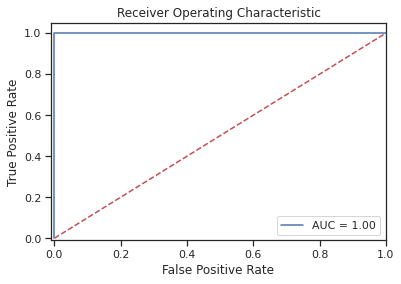

In [61]:
import sklearn.metrics as metrics# calculate the fpr and tpr for all thresholds of the classification
probs = pipe.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-.01, 1.])
plt.ylim([-.01, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

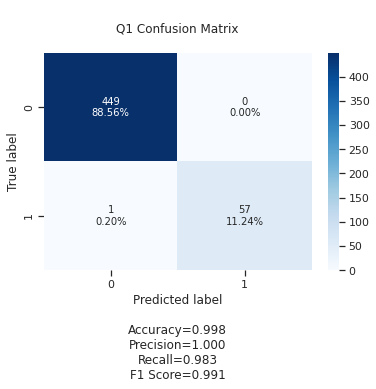

In [62]:
for title, cf, y_t, y_pred, y_prob in zip(Q, te_confusions, y_test, y_test_preds, te_probs):
    make_confusion_matrix(cf, title='\n'+title+' Confusion Matrix\n')


In [63]:
results_table

,company,job_title,state,city,rating,target,salary,dateposted,summary,url,...,Q1_probabilities,Q2_y_test,Q2_pred y,Q2_probabilities,Q3_y_test,Q3_pred y,Q3_probabilities,Q4_y_test,Q4_pred y,Q4_probabilities
2310,fresenius medical care,machine learning engineer,ma,remote in lexington,3.4,NaN,NaN,2022-06-21,"strong technical skills in machine learning, d...",https://www.indeed.com/rc/clk?jk=7bc3283cf3a3a...,...,"[0.9938515911997293, 0.006148408800270664]",0,0,"[0.992048682834667, 0.007951317165333073]",0,0,"[0.9956694042920561, 0.0043305957079439366]",0,0,"[0.9949361097817082, 0.005063890218291768]"
2058,alight,data science director - 100% virtual,remote in illinois,remote in illinois,3.1,NaN,NaN,2022-06-21,hands on experience leading large-scale global...,https://www.indeed.com/rc/clk?jk=27fa26e1eb388...,...,"[0.982392053630548, 0.017607946369451972]",0,0,"[0.9896359328539278, 0.010364067146072211]",0,0,"[0.9852941863661017, 0.014705813633898375]",0,0,"[0.9907752368730727, 0.009224763126927273]"
194,e ink,modeling research scientist - deep learning ce...,ma,billerica,4.2,2.0,102000.0,2022-06-22,activities include executing electro-optical e...,https://www.indeed.com/rc/clk?jk=93fa6a57d03f4...,...,"[0.9902616357368045, 0.009738364263195501]",1,1,"[0.09051737289411399, 0.909482627105886]",0,0,"[0.9911766686318277, 0.008823331368172283]",0,0,"[0.9929217917798466, 0.007078208220153351]"
1393,citi,mrm senior vice president of artificial intell...,ny,queens,3.9,NaN,NaN,2022-06-22,oversee the group’s work to ensure adherence t...,https://www.indeed.com/rc/clk?jk=c4e8d8235eb14...,...,"[0.9941420171062022, 0.005857982893797835]",0,0,"[0.991098193398326, 0.008901806601673957]",0,0,"[0.9905551513181415, 0.009444848681858504]",0,0,"[0.996320159425918, 0.003679840574082014]"
764,humana,senior data scientist/informaticist (physician...,ky,remote in louisville,3.6,NaN,NaN,2022-06-20,bachelor's degree and 5+ years of data analyti...,https://www.indeed.com/rc/clk?jk=fb7cb812f4734...,...,"[0.9699891334945621, 0.03001086650543792]",0,0,"[0.9825360217469513, 0.017463978253048636]",0,0,"[0.9845051941163696, 0.01549480588363042]",0,0,"[0.9907397326196921, 0.00926026738030791]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,collins aerospace,data science and supportability engineer (remote),tx,remote in richardson,3.6,NaN,NaN,2022-06-22,coordinate and lead discussions with project m...,https://www.indeed.com/rc/clk?jk=ab040782dca54...,...,"[0.991084225437705, 0.008915774562294995]",0,0,"[0.9940988635131683, 0.0059011364868317056]",0,0,"[0.9808209957573131, 0.0191790042426869]",0,0,"[0.9945183190596927, 0.005481680940307265]"
76,vaya health,sr. data analyst - healthcare analytics,remote in north carolina,remote in north carolina,3.3,1.0,96000.0,2022-06-21,"the senior data analyst, healthcare analytics ...",https://www.indeed.com/rc/clk?jk=c69f5eeb35933...,...,"[0.2059864698210061, 0.7940135301789939]",0,0,"[0.9770780514062085, 0.022921948593791482]",0,0,"[0.9862241164724143, 0.013775883527585747]",0,0,"[0.9847272457045403, 0.015272754295459724]"
432,garrett advancing motion,sr data scientist,ga,atlanta,3.8,2.0,116000.0,2022-06-21,make data-driven decisions through big data an...,https://www.indeed.com/rc/clk?jk=8ab894f23eb9f...,...,"[0.9861556777558076, 0.013844322244192386]",1,1,"[0.13697532199155027, 0.8630246780084497]",0,0,"[0.9930789415425179, 0.006921058457482179]",0,0,"[0.9934563165957521, 0.006543683404247985]"
1048,shopify,"lead (staff) data scientist (remote, united st...",tx,remote in dallas,3.8,NaN,NaN,2022-06-22,from pipelines and schema design to machine le...,https://www.indeed.com/rc/clk?jk=5a189530ecbca...,...,"[0.9920615837673152, 0.007938416232684781]",0,0,"[0.9920934679254663, 0.007906532074533717]",0,0,"[0.9808433889555684, 0.019156611044431573]",0,0,"[0.9930026850626357, 0.006997314937364348]"


In [64]:
def Q(row):
    """Subtracts the distance (in days) provided by the postD function.
    Args:
        row (record in the data): record

    Returns:
        datetime object: extract date - relative age = actual post date
    """
    #np.argmax(row[['Q1_Prob', 'Q2_Prob','Q3_Prob','Q4_Prob']].values)
    Q1 = row['Q1_probabilities'][1]
    Q2 = row['Q2_probabilities'][1]
    Q3 = row['Q3_probabilities'][1]
    Q4 = row['Q4_probabilities'][1]
    lst = [Q1,Q2,Q3,Q4]
    # adding 1 so these correspond to the target names rather than 0 indexed.
    return int(lst.index(max(lst))+1)
    #next, check if that 


results_table['Q'] = results_table.apply( lambda row : Q(row), axis = 1)
results_table


,company,job_title,state,city,rating,target,salary,dateposted,summary,url,...,Q2_y_test,Q2_pred y,Q2_probabilities,Q3_y_test,Q3_pred y,Q3_probabilities,Q4_y_test,Q4_pred y,Q4_probabilities,Q
2310,fresenius medical care,machine learning engineer,ma,remote in lexington,3.4,NaN,NaN,2022-06-21,"strong technical skills in machine learning, d...",https://www.indeed.com/rc/clk?jk=7bc3283cf3a3a...,...,0,0,"[0.992048682834667, 0.007951317165333073]",0,0,"[0.9956694042920561, 0.0043305957079439366]",0,0,"[0.9949361097817082, 0.005063890218291768]",2
2058,alight,data science director - 100% virtual,remote in illinois,remote in illinois,3.1,NaN,NaN,2022-06-21,hands on experience leading large-scale global...,https://www.indeed.com/rc/clk?jk=27fa26e1eb388...,...,0,0,"[0.9896359328539278, 0.010364067146072211]",0,0,"[0.9852941863661017, 0.014705813633898375]",0,0,"[0.9907752368730727, 0.009224763126927273]",1
194,e ink,modeling research scientist - deep learning ce...,ma,billerica,4.2,2.0,102000.0,2022-06-22,activities include executing electro-optical e...,https://www.indeed.com/rc/clk?jk=93fa6a57d03f4...,...,1,1,"[0.09051737289411399, 0.909482627105886]",0,0,"[0.9911766686318277, 0.008823331368172283]",0,0,"[0.9929217917798466, 0.007078208220153351]",2
1393,citi,mrm senior vice president of artificial intell...,ny,queens,3.9,NaN,NaN,2022-06-22,oversee the group’s work to ensure adherence t...,https://www.indeed.com/rc/clk?jk=c4e8d8235eb14...,...,0,0,"[0.991098193398326, 0.008901806601673957]",0,0,"[0.9905551513181415, 0.009444848681858504]",0,0,"[0.996320159425918, 0.003679840574082014]",3
764,humana,senior data scientist/informaticist (physician...,ky,remote in louisville,3.6,NaN,NaN,2022-06-20,bachelor's degree and 5+ years of data analyti...,https://www.indeed.com/rc/clk?jk=fb7cb812f4734...,...,0,0,"[0.9825360217469513, 0.017463978253048636]",0,0,"[0.9845051941163696, 0.01549480588363042]",0,0,"[0.9907397326196921, 0.00926026738030791]",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,collins aerospace,data science and supportability engineer (remote),tx,remote in richardson,3.6,NaN,NaN,2022-06-22,coordinate and lead discussions with project m...,https://www.indeed.com/rc/clk?jk=ab040782dca54...,...,0,0,"[0.9940988635131683, 0.0059011364868317056]",0,0,"[0.9808209957573131, 0.0191790042426869]",0,0,"[0.9945183190596927, 0.005481680940307265]",3
76,vaya health,sr. data analyst - healthcare analytics,remote in north carolina,remote in north carolina,3.3,1.0,96000.0,2022-06-21,"the senior data analyst, healthcare analytics ...",https://www.indeed.com/rc/clk?jk=c69f5eeb35933...,...,0,0,"[0.9770780514062085, 0.022921948593791482]",0,0,"[0.9862241164724143, 0.013775883527585747]",0,0,"[0.9847272457045403, 0.015272754295459724]",1
432,garrett advancing motion,sr data scientist,ga,atlanta,3.8,2.0,116000.0,2022-06-21,make data-driven decisions through big data an...,https://www.indeed.com/rc/clk?jk=8ab894f23eb9f...,...,1,1,"[0.13697532199155027, 0.8630246780084497]",0,0,"[0.9930789415425179, 0.006921058457482179]",0,0,"[0.9934563165957521, 0.006543683404247985]",2
1048,shopify,"lead (staff) data scientist (remote, united st...",tx,remote in dallas,3.8,NaN,NaN,2022-06-22,from pipelines and schema design to machine le...,https://www.indeed.com/rc/clk?jk=5a189530ecbca...,...,0,0,"[0.9920934679254663, 0.007906532074533717]",0,0,"[0.9808433889555684, 0.019156611044431573]",0,0,"[0.9930026850626357, 0.006997314937364348]",3


In [65]:

ohe = OneHotEncoder(sparse=False)
#results_table = results_table.join(pd.DataFrame(ohe.fit_transform(results_table[['Q']]), columns=['Q1','Q2','Q3','Q4']))


In [66]:
ohe = ohe.fit_transform(results_table[['Q']]).T

results_table['Q1'] = ohe[0]
results_table['Q2'] = ohe[1]
results_table['Q3'] = ohe[2]
results_table['Q4'] = ohe[3]

results_table

,company,job_title,state,city,rating,target,salary,dateposted,summary,url,...,Q3_pred y,Q3_probabilities,Q4_y_test,Q4_pred y,Q4_probabilities,Q,Q1,Q2,Q3,Q4
2310,fresenius medical care,machine learning engineer,ma,remote in lexington,3.4,NaN,NaN,2022-06-21,"strong technical skills in machine learning, d...",https://www.indeed.com/rc/clk?jk=7bc3283cf3a3a...,...,0,"[0.9956694042920561, 0.0043305957079439366]",0,0,"[0.9949361097817082, 0.005063890218291768]",2,0.0,1.0,0.0,0.0
2058,alight,data science director - 100% virtual,remote in illinois,remote in illinois,3.1,NaN,NaN,2022-06-21,hands on experience leading large-scale global...,https://www.indeed.com/rc/clk?jk=27fa26e1eb388...,...,0,"[0.9852941863661017, 0.014705813633898375]",0,0,"[0.9907752368730727, 0.009224763126927273]",1,1.0,0.0,0.0,0.0
194,e ink,modeling research scientist - deep learning ce...,ma,billerica,4.2,2.0,102000.0,2022-06-22,activities include executing electro-optical e...,https://www.indeed.com/rc/clk?jk=93fa6a57d03f4...,...,0,"[0.9911766686318277, 0.008823331368172283]",0,0,"[0.9929217917798466, 0.007078208220153351]",2,0.0,1.0,0.0,0.0
1393,citi,mrm senior vice president of artificial intell...,ny,queens,3.9,NaN,NaN,2022-06-22,oversee the group’s work to ensure adherence t...,https://www.indeed.com/rc/clk?jk=c4e8d8235eb14...,...,0,"[0.9905551513181415, 0.009444848681858504]",0,0,"[0.996320159425918, 0.003679840574082014]",3,0.0,0.0,1.0,0.0
764,humana,senior data scientist/informaticist (physician...,ky,remote in louisville,3.6,NaN,NaN,2022-06-20,bachelor's degree and 5+ years of data analyti...,https://www.indeed.com/rc/clk?jk=fb7cb812f4734...,...,0,"[0.9845051941163696, 0.01549480588363042]",0,0,"[0.9907397326196921, 0.00926026738030791]",1,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,collins aerospace,data science and supportability engineer (remote),tx,remote in richardson,3.6,NaN,NaN,2022-06-22,coordinate and lead discussions with project m...,https://www.indeed.com/rc/clk?jk=ab040782dca54...,...,0,"[0.9808209957573131, 0.0191790042426869]",0,0,"[0.9945183190596927, 0.005481680940307265]",3,0.0,0.0,1.0,0.0
76,vaya health,sr. data analyst - healthcare analytics,remote in north carolina,remote in north carolina,3.3,1.0,96000.0,2022-06-21,"the senior data analyst, healthcare analytics ...",https://www.indeed.com/rc/clk?jk=c69f5eeb35933...,...,0,"[0.9862241164724143, 0.013775883527585747]",0,0,"[0.9847272457045403, 0.015272754295459724]",1,1.0,0.0,0.0,0.0
432,garrett advancing motion,sr data scientist,ga,atlanta,3.8,2.0,116000.0,2022-06-21,make data-driven decisions through big data an...,https://www.indeed.com/rc/clk?jk=8ab894f23eb9f...,...,0,"[0.9930789415425179, 0.006921058457482179]",0,0,"[0.9934563165957521, 0.006543683404247985]",2,0.0,1.0,0.0,0.0
1048,shopify,"lead (staff) data scientist (remote, united st...",tx,remote in dallas,3.8,NaN,NaN,2022-06-22,from pipelines and schema design to machine le...,https://www.indeed.com/rc/clk?jk=5a189530ecbca...,...,0,"[0.9808433889555684, 0.019156611044431573]",0,0,"[0.9930026850626357, 0.006997314937364348]",3,0.0,0.0,1.0,0.0


In [67]:
results_table.columns

Index(['company', 'job_title', 'state', 'city', 'rating', 'target', 'salary',
       'dateposted', 'summary', 'url', 'comment_text_lem', 'Q1_y_test',
       'Q1_pred y', 'Q1_probabilities', 'Q2_y_test', 'Q2_pred y',
       'Q2_probabilities', 'Q3_y_test', 'Q3_pred y', 'Q3_probabilities',
       'Q4_y_test', 'Q4_pred y', 'Q4_probabilities', 'Q', 'Q1', 'Q2', 'Q3',
       'Q4'],
      dtype='object')

In [68]:
#TODO CLean out all these nans Way upstream

In [69]:
results_table.to_csv(f'../app/data/tableau_table.csv', index=False)


In [70]:
results_table=results_table[results_table.salary.notna()]
results_table[results_table.Q != results_table.target]

,company,job_title,state,city,rating,target,salary,dateposted,summary,url,...,Q3_pred y,Q3_probabilities,Q4_y_test,Q4_pred y,Q4_probabilities,Q,Q1,Q2,Q3,Q4


In [71]:
results_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129 entries, 194 to 432
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   company           129 non-null    object 
 1   job_title         129 non-null    object 
 2   state             129 non-null    object 
 3   city              129 non-null    object 
 4   rating            129 non-null    float64
 5   target            129 non-null    float64
 6   salary            129 non-null    float64
 7   dateposted        129 non-null    object 
 8   summary           129 non-null    object 
 9   url               129 non-null    object 
 10  comment_text_lem  129 non-null    object 
 11  Q1_y_test         129 non-null    int64  
 12  Q1_pred y         129 non-null    int64  
 13  Q1_probabilities  129 non-null    object 
 14  Q2_y_test         129 non-null    int64  
 15  Q2_pred y         129 non-null    int64  
 16  Q2_probabilities  129 non-null    object 


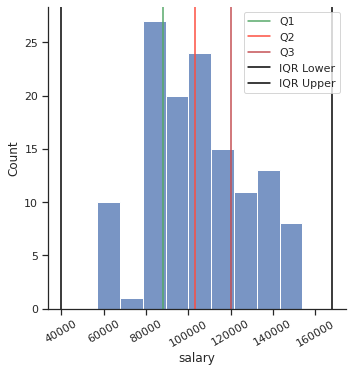

In [72]:
q1 = np.quantile(results_table.salary, 0.25)
q2 = np.quantile(results_table.salary, 0.5)
q3 = np.quantile(results_table.salary, 0.75)

# calc iqr
iqr = (q3 - q1)
# expand iqr to discern outliers
iqr_x = iqr*1.5

# setting the lower and upper limits
iqr_lower = q1-iqr_x
iqr_upper = q3+iqr_x


sns.displot(results_table.salary)
plt.axvline(x=q1, label="Q1", c = 'g')
plt.axvline(x=q2, label="Q2", c = '#fd4d3f')
plt.axvline(x=q3, label="Q3", c = 'r')

plt.axvline(x=iqr_lower, label = 'IQR Lower', c = 'black')
plt.axvline(x=iqr_upper, label = 'IQR Upper', c = 'black')
plt.xticks(rotation=30)
plt.legend()
plt.show()

In [73]:
results_table.Q.value_counts()

1    58
2    35
3    26
4    10
Name: Q, dtype: int64

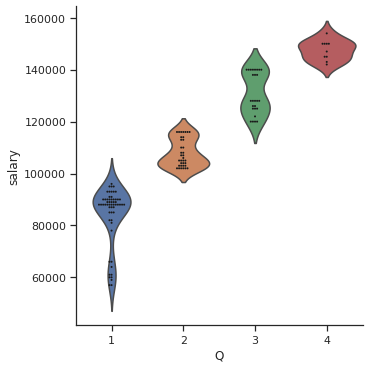

In [74]:
g = sns.catplot(x="Q", y="salary", kind="violin", inner=None, data=results_table)
sns.swarmplot(x="Q", y="salary", color="k", size=2, data=results_table, ax=g.ax)

plt.xticks(rotation=0)

plt.show()

In [75]:
city------------
colmax == 'q3_PROB', probably taken from col name
Company------------
Date Posted----------------
Description
Focus
Job title
JobUrl
Location
Q
Requirements
Role
Schedule
State
Summary
Probability
Q1 = 0 or 1 or null
Q1_posts = 1.0 or 0.0
Q1 pred = binary
Q1 probs

etc

Salary


top terms:
Feature = values == term
Q = class == 'Q1', etc
Imortance == some float

top states:
the same but Feature = states, capitalized

SyntaxError: invalid syntax (<ipython-input-75-a67e56a088d6>, line 1)

In [ ]:

X_tfidf = tfidf.fit_transform(_test).toarray()
vocab = q1_vectorizer.vocabulary_
reverse_vocab = {v:k for k,v in vocab.items()}

feature_names = tfidf.get_feature_names()
df_tfidf = pd.DataFrame(X_tfidf, columns = feature_names)

idx = X_tfidf.argsort(axis=1)

tfidf_max10 = idx[:,-10:]

df_tfidf['top10'] = [[reverse_vocab.get(item) for item in row] for row in tfidf_max10 ]

df_tfidf['top10']
